In [1]:
!pip install wget
!pip install PyGithub
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=32aa61ca5b64de7f2a5166b090cc70264c49b853ad89a009a2c307cfe4d804c2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 291 kB 2.2 MB/s 
     |████████████████████████████████| 856 kB 40.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from os import path

import glob
import pandas as pd
import numpy as np
import wget
from github import Github
import shutil

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

import tensorflow as tf

# signal processing
from scipy import signal
from scipy.ndimage import label as sci_label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

In [3]:
print(tf.__version__)

2.8.2


In [ ]:
%matplotlib inline
%pylab inline
import warnings
import itertools    
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

sns.set_style('dark')

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime', 'trapz']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
stimulus_desc_file = pd.read_excel('/content/drive/MyDrive/Emotion-RST/YAAD/data/ECG_GSR_Emotions/Stimulus_Description.xlsx')
stimulus_desc_file.to_csv('Stimulus_Description.csv', index = None, header=True)
stimulus_desc = pd.read_csv('Stimulus_Description.csv')

In [ ]:
self_annotation_multimodal_file = pd.read_excel('/content/drive/MyDrive/Emotion-RST/YAAD/data/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx')
self_annotation_multimodal_file.to_csv('Self-annotation Multimodal_Use.csv', index = None, header=True)
self_annotation_multimodal = pd.read_csv('Self-annotation Multimodal_Use.csv')
self_annotation_multimodal['annotation'] = 'M'
self_annotation_multimodal.rename(columns = {'V_Label':'Valence', 'A_Label':'Arousal', 'Four_Labels':'Four_Label'}, inplace = True)

In [ ]:
self_annotation_singlemodal_file = pd.read_excel('/content/drive/MyDrive/Emotion-RST/YAAD/data/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx')
self_annotation_singlemodal_file.to_csv('Self-annotation Single Modal_Use.csv', index = None, header=True)
self_annotation_singlemodal = pd.read_csv('Self-annotation Single Modal_Use.csv')
self_annotation_singlemodal['annotation'] = 'S'
self_annotation_singlemodal.rename(columns = {'Male':'Gender', 'Session Id':'Session ID', 'Video Id':'Video ID'}, inplace = True)

In [ ]:
self_annotation_frames = [self_annotation_multimodal, self_annotation_singlemodal]
merged_dataframe = pd.concat(self_annotation_frames)
#merged_dataframe.head()
#merged_dataframe.tail()
table_frame = merged_dataframe.copy()

In [ ]:
cols = []
cols.append('Raw Data')
for col in merged_dataframe.columns:
    cols.append(col)

In [ ]:
arr_shape = 1000
raw_data_arr = []

def form_data(data_array = [], annotation = '', data_path = ''):
    #######
    #
    #     If anyone could help me improve this code please do so.
    #     Goals was to product the same data format of raw_dataframe DF below.
    #
    #######
    for filename in os.listdir(data_path):
            data = np.loadtxt(os.path.join(data_path, filename), delimiter=',')
            data = data[0:arr_shape]
            filenames = filename.split('ECGdata_')[1]
            filenames = filenames.split('.dat')[0]
            filenames = filenames.lower()
            s = filenames.split('s')[1].split('p');
            p = s[1].split('v')
            s = s[0]
            v = p[1]
            p = p[0]
            data_row = merged_dataframe.loc[(merged_dataframe['Session ID'] == int(s)) & 
                             (merged_dataframe['Participant Id'] == int(p)) & 
                             (merged_dataframe['Video ID'] == int(v)) &
                             (merged_dataframe['annotation'] == 'M')]
            stim_row = stimulus_desc.loc[(stimulus_desc['Session ID'] == int(s)) & 
                             (stimulus_desc['Video ID'] == int(v))]
            for index, row in data_row.iterrows():
              data_array.append([data, 
                                   row['Participant Id'], row['Session ID'], row['Video ID'],
                                   row['Name'], row['Age'], row['Gender'], row['Valence level'],
                                   row['Arousal level'], row['Dominance level'], row['Happy'],
                                   row['Sad'], row['Fear'], row['Anger'], row['Neutral'],
                                   row['Disgust'], row['Surprised'], row['Familiarity Score'],
                                   row['Emotion'], row['Valence'], row['Arousal'], row['Four_Label'],
                                   row['annotation'],  stim_row['Target Emotion'].iat[0]
                                   ])
    return data_array

    
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'M', data_path = "/content/drive/MyDrive/Emotion-RST/YAAD/data/ECG_GSR_Emotions/Raw Data/Multimodal/ECG/")
raw_data_arr =  form_data(data_array = raw_data_arr, annotation = 'S', data_path = "/content/drive/MyDrive/Emotion-RST/YAAD/data/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/")
cols.append('Target Emotion')
raw_dataframe = pd.DataFrame(raw_data_arr, columns = cols)
raw_dataframe.rename(columns = {'Participant Id':'Participant ID', 'annotation':'Modal', 'Four_Label':'Four label'}, inplace = True)
raw_dataframe['Familiarity Score'] = raw_dataframe['Familiarity Score'].fillna('Never watched')
raw_dataframe = raw_dataframe.replace(np.nan, '', regex=True)

In [ ]:
plot_frame = raw_dataframe.copy()

In [ ]:
plot_frame = plot_frame.drop(['Participant ID', 'Session ID', 'Familiarity Score', 'Age', 'Gender', 'Name'], axis = 1)
sad_data = plot_frame.loc[(plot_frame['Emotion'] == 'Sad') & (plot_frame['Target Emotion'] == 'sad')] 
fear_data = plot_frame.loc[(plot_frame['Emotion'] == 'Fear')  & (plot_frame['Target Emotion'] == 'fear')]
happy_data = plot_frame.loc[(plot_frame['Emotion'] == 'Happy') & (plot_frame['Target Emotion'] == 'happy')]
anger_data = plot_frame.loc[(plot_frame['Emotion'] == 'Anger') & (plot_frame['Target Emotion'] == 'anger')]
neutral_data = plot_frame.loc[(plot_frame['Emotion'] == 'Neutral') & (plot_frame['Target Emotion'] == 'neutral')]
mixed_data = plot_frame.loc[(plot_frame['Emotion'] == 'Mixed') & (plot_frame['Target Emotion'] == 'neutral')]
disgust_data = plot_frame.loc[(plot_frame['Emotion'] == 'Disgust') & (plot_frame['Target Emotion'] == 'disgust')]
surprised_data = plot_frame.loc[(plot_frame['Emotion'] == 'Surprise') & (plot_frame['Target Emotion'] == 'surprise')]

In [ ]:
def plot_signals(data_arr, title = ''):
    plt.clf()
    plt.figure(figsize=(12, 4))
    
    for index, row in data_arr.iterrows():
        y = row['Raw Data']
        plt.plot(y)
        #x = np.arange(y.size)
        #plt.plot(x, y)
    
    plt.tight_layout()
    plt.title(title)
    plt.show()

<Figure size 432x288 with 0 Axes>

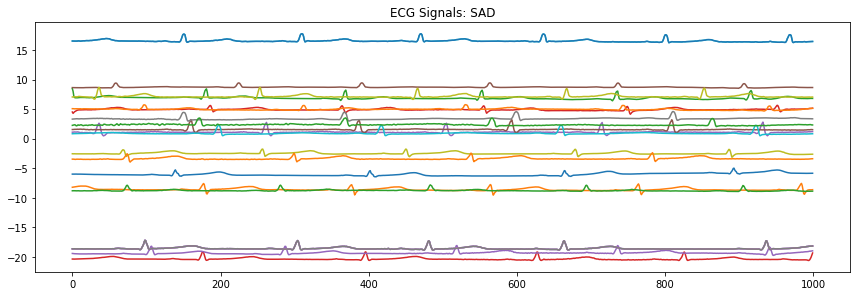

In [ ]:
plot_signals(data_arr = sad_data, title = 'ECG Signals: SAD')

<Figure size 432x288 with 0 Axes>

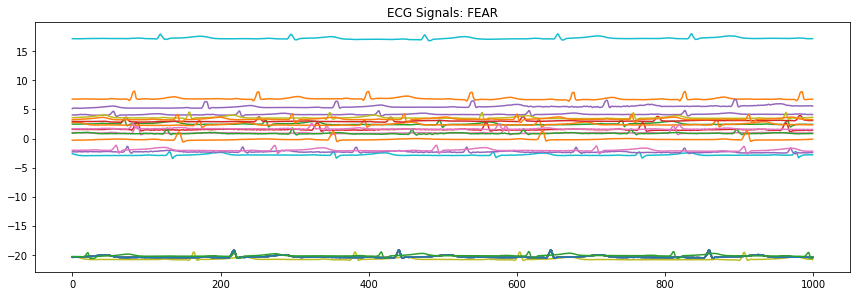

In [ ]:
plot_signals(data_arr = fear_data, title = 'ECG Signals: FEAR')

<Figure size 432x288 with 0 Axes>

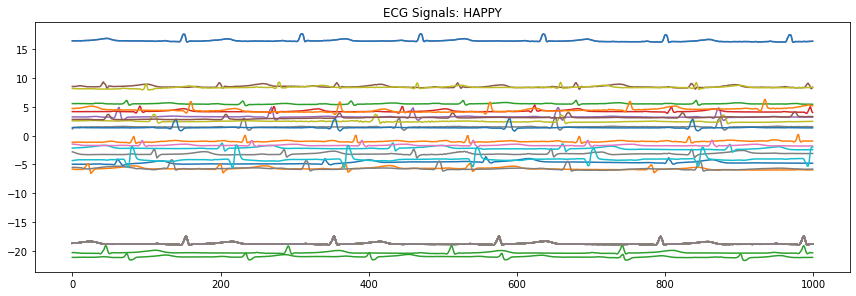

In [ ]:
plot_signals(data_arr = happy_data, title = 'ECG Signals: HAPPY')

<Figure size 432x288 with 0 Axes>

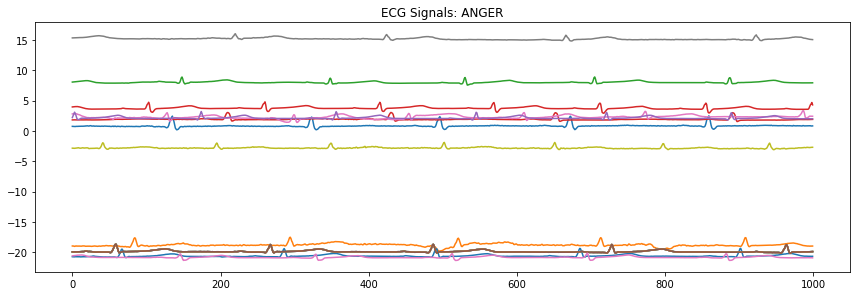

In [ ]:
plot_signals(data_arr = anger_data, title = 'ECG Signals: ANGER')

<Figure size 432x288 with 0 Axes>

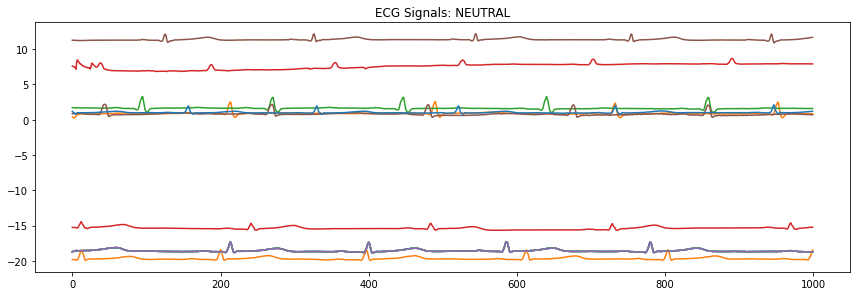

In [ ]:
plot_signals(data_arr = neutral_data, title = 'ECG Signals: NEUTRAL')

<Figure size 432x288 with 0 Axes>

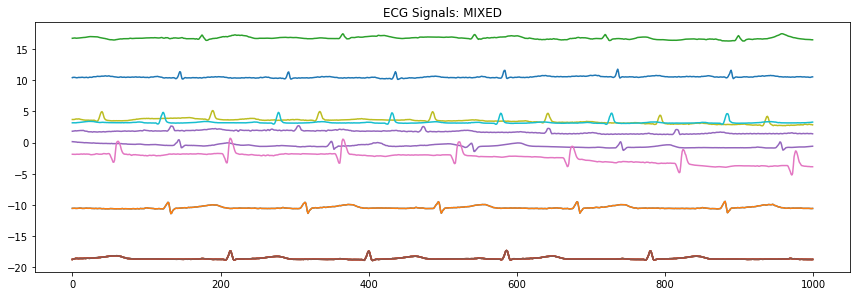

In [ ]:
plot_signals(data_arr = mixed_data, title = 'ECG Signals: MIXED')

<Figure size 432x288 with 0 Axes>

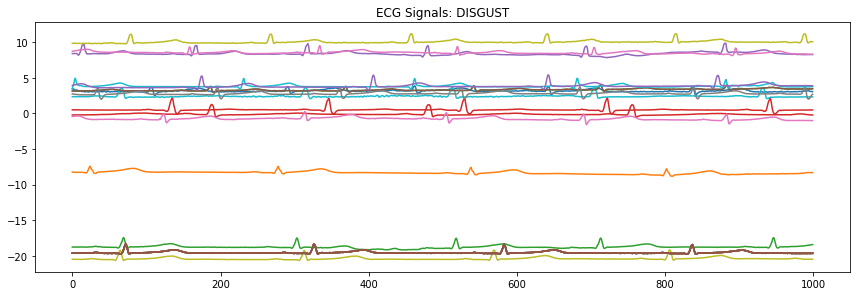

In [ ]:
plot_signals(data_arr = disgust_data, title = 'ECG Signals: DISGUST')

<Figure size 432x288 with 0 Axes>

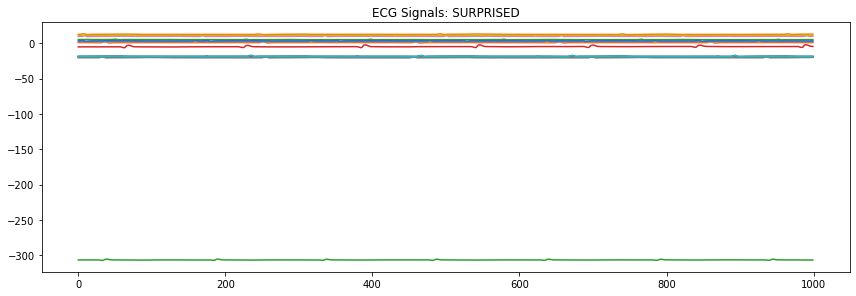

In [ ]:
plot_signals(data_arr = surprised_data, title = 'ECG Signals: SURPRISED')

In [ ]:
#train_d_frame = plot_frame.copy().drop(['Video ID', 'Valence level', 'Arousal level',
#                                        'Dominance level', 'Happy', 'Sad', 'Fear',
#                                        'Anger', 'Neutral', 'Disgust', 'Surprised',
#                                        'Valence', 'Arousal', 'Four label', 'Modal'
#                                       ], axis = 1)
train_d_frame = plot_frame.copy().drop(['Video ID', 'Happy', 'Sad', 'Fear',
                                        'Anger', 'Neutral', 'Disgust', 'Surprised', 'Four label', 'Modal'
                                       ], axis = 1)
train_d_frame.rename(columns = {'Raw Data':'feature', 'Emotion':'emotion'}, inplace = True)
#train_d_frame.head()

In [ ]:
train_d_frame

,feature,Valence level,Arousal level,Dominance level,emotion,Valence,Arousal,Target Emotion
0,"[-4.96, -4.9633, -4.9583, -4.959, -4.9552, -4....",7,2,0,Happy,HV,LA,happy
1,"[-5.9868, -5.9908, -5.9927, -5.9869, -5.9778, ...",3,5,0,Sad,LV,LA,sad
2,"[2.732, 2.7337, 2.7454, 2.754, 2.7657, 2.7899,...",4,0,0,Mixed,LV,LA,fear
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,4,2,Mixed,LV,LA,sad
4,"[5.754, 5.7436, 5.8045, 5.8732, 5.806, 5.7849,...",3,2,1,Sad,LV,LA,anger
...,...,...,...,...,...,...,...,...
394,"[-1.8641, -1.8731, -1.8956, -1.8955, -1.8831, ...",5,4,4,Mixed,LV,LA,neutral
395,"[2.4423, 2.4517, 2.448, 2.4557, 2.4535, 2.4656...",4,4,9,Surprise,LV,LA,neutral
396,"[-20.306, -20.321, -20.322, -20.318, -20.309, ...",0,9,0,Fear,LV,HA,fear
397,"[14.621, 14.622, 14.612, 14.609, 14.612, 14.62...",1,2,1,Sad,LV,LA,anger


In [ ]:
"""valence_ = []
high_valence_num=0
low_valence_num=0
for i in range(len(train_d_frame)):
  #print(i)
  row_data = train_d_frame.loc[i]
  valence = train_d_frame['Valence level'][i]
  if(valence>=5):
    #print(valence,"high-valence")
    high_valence_num = high_valence_num + 1
  elif(valence<=3):
    #print(valence,"low-valence")
    low_valence_num = low_valence_num + 1
  else:
    ##Mid Valence
    pass

print(high_valence_num)
print(low_valence_num)"""

'valence_ = []\nhigh_valence_num=0\nlow_valence_num=0\nfor i in range(len(train_d_frame)):\n  #print(i)\n  row_data = train_d_frame.loc[i]\n  valence = train_d_frame[\'Valence level\'][i]\n  if(valence>=5):\n    #print(valence,"high-valence")\n    high_valence_num = high_valence_num + 1\n  elif(valence<=3):\n    #print(valence,"low-valence")\n    low_valence_num = low_valence_num + 1\n  else:\n    ##Mid Valence\n    pass\n\nprint(high_valence_num)\nprint(low_valence_num)'

In [ ]:
le = LabelEncoder()
train_d_frame['Valence'] = le.fit_transform(train_d_frame['Valence'])
train_d_frame['Arousal'] = le.fit_transform(train_d_frame['Arousal'])
train_d_frame.head()

,feature,Valence level,Arousal level,Dominance level,emotion,Valence,Arousal,Target Emotion
0,"[-4.96, -4.9633, -4.9583, -4.959, -4.9552, -4....",7,2,0,Happy,0,1,happy
1,"[-5.9868, -5.9908, -5.9927, -5.9869, -5.9778, ...",3,5,0,Sad,1,1,sad
2,"[2.732, 2.7337, 2.7454, 2.754, 2.7657, 2.7899,...",4,0,0,Mixed,1,1,fear
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,4,2,Mixed,1,1,sad
4,"[5.754, 5.7436, 5.8045, 5.8732, 5.806, 5.7849,...",3,2,1,Sad,1,1,anger


In [ ]:
x = np.array(train_d_frame['feature'].tolist())
y = np.array(train_d_frame['Valence'].tolist())

In [ ]:
sc = StandardScaler()
x = sc.fit_transform(x)

In [ ]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
num_labels = y.shape[1]

In [154]:
print("x_train",x_train.shape)
print("y_train",y_train.shape)
print("x_test",x_test.shape)
print("y_test",y_test.shape)

x_train (319, 1000)
y_train (319, 2)
x_test (80, 1000)
y_test (80, 2)


In [ ]:
model = Sequential()

###first layer
model.add(Dense(1, input_shape = (arr_shape,)))
model.add(Activation('relu'))

###second layer
model.add(Dense(2))
model.add(Activation('relu'))

###third layer
model.add(Dense(4))
model.add(Activation('relu'))

###fourth layer
model.add(Dense(8))
model.add(Activation('relu'))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1)                 1001      
                                                                 
 activation_5 (Activation)   (None, 1)                 0         
                                                                 
 dense_6 (Dense)             (None, 2)                 4         
                                                                 
 activation_6 (Activation)   (None, 2)                 0         
                                                                 
 dense_7 (Dense)             (None, 4)                 12        
                                                                 
 activation_7 (Activation)   (None, 4)                 0         
                                                                 
 dense_8 (Dense)             (None, 8)                

In [ ]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [ ]:
num_epochs = 50
num_batch_size = 3

checkpointer = ModelCheckpoint(filepath = './Raw Data/ecg_emotion_recognizer.hdf5', 
                               verbose = 1, save_best_only = True)
start = datetime.now()

model.fit(x_train, y_train, batch_size = num_batch_size, epochs = num_epochs,
        validation_data = (x_test, y_test), callbacks = [checkpointer], verbose = 1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
141/160 [=========================>....] - ETA: 0s - loss: 0.6461 - accuracy: 0.6560
Epoch 1: val_loss improved from inf to 0.64992, saving model to ./Raw Data/ecg_emotion_recognizer.hdf5
160/160 [==============================] - 0s 3ms/step - loss: 0.6348 - accuracy: 0.6740 - val_loss: 0.6499 - val_accuracy: 0.6500
Epoch 2/100
146/160 [==========================>...] - ETA: 0s - loss: 0.6314 - accuracy: 0.6747
Epoch 2: val_loss did not improve from 0.64992
160/160 [==============================] - 0s 3ms/step - loss: 0.6318 - accuracy: 0.6740 - val_loss: 0.6529 - val_accuracy: 0.6500
Epoch 3/100
149/160 [==========================>...] - ETA: 0s - loss: 0.6354 - accuracy: 0.6711
Epoch 3: val_loss did not improve from 0.64992
160/160 [==============================] - 0s 3ms/step - loss: 0.6327 - accuracy: 0.6740 - val_loss: 0.6536 - val_accuracy: 0.6500
Epoch 4/100
140/160 [=========================>....] - ETA: 0s - loss: 0.6238 - accuracy: 0.6857
Epoch 4: val_loss did 

In [158]:
x_train.shape


(319, 1000)

In [161]:
i_lstm = Input(shape=(x_train.shape[1], 1))

x_lstm = LSTM(32, return_sequences=True)(i_lstm)
x_lstm = Flatten()(x_lstm)
y_lstm = Dense(2, activation='softmax')(x_lstm)

model_lstm = Model(i_lstm, y_lstm)

model_lstm.summary()
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_lstm_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
                                    
model_lstm.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
lstm_h = model_lstm.fit(x_train, y_train,
                   batch_size=8,
                   validation_data=(x_test, y_test),
                   epochs=20,
                   callbacks=[es, mc, lr_schedule])

KeyboardInterrupt: ignored

In [ ]:
test_accuracy = model_lstm.evaluate(x_test, y_test, verbose = 0)
print(test_accuracy)

[0.6424469947814941, 0.6499999761581421]


In [ ]:
test_accuracy = model.evaluate(x_test, y_test, verbose = 0)
print(test_accuracy)

[0.6485626101493835, 0.6499999761581421]


# RSL

In [ ]:
# Data manipulation
import pandas as pd

# Visualization
import plotly.express as px

# Sklearn
from sklearn.model_selection import train_test_split # for splitting data into train and test samples
from sklearn.svm import SVC # for Support Vector Classification baseline model
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning
from sklearn.metrics import classification_report # for model evaluation metrics
from sklearn.metrics import f1_score

from sklearn.utils import shuffle
import math
import os
import numpy as np

import random

import time
import datetime

In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220719082949.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949


In [ ]:
!pip install tensorflow==1.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 27 kB/s 
     |████████████████████████████████| 488 kB 11.2 MB/s 
     |████████████████████████████████| 50 kB 1.4 MB/s 
     |████████████████████████████████| 3.1 MB 3.8 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.14.0 which is incompatible.


In [ ]:
#第一步，import
import tensorflow as tf #导入模块
from sklearn import datasets #从sklearn中导入数据集
import numpy as np #导入科学计算模块
print(tf.__version__)

2.8.2


In [ ]:
train_d_frame

,feature,Valence level,Arousal level,Dominance level,emotion,Valence,Arousal,Target Emotion
0,"[-4.96, -4.9633, -4.9583, -4.959, -4.9552, -4....",7,2,0,Happy,0,1,happy
1,"[-5.9868, -5.9908, -5.9927, -5.9869, -5.9778, ...",3,5,0,Sad,1,1,sad
2,"[2.732, 2.7337, 2.7454, 2.754, 2.7657, 2.7899,...",4,0,0,Mixed,1,1,fear
3,"[-18.619, -18.624, -18.615, -18.604, -18.616, ...",5,4,2,Mixed,1,1,sad
4,"[5.754, 5.7436, 5.8045, 5.8732, 5.806, 5.7849,...",3,2,1,Sad,1,1,anger
...,...,...,...,...,...,...,...,...
394,"[-1.8641, -1.8731, -1.8956, -1.8955, -1.8831, ...",5,4,4,Mixed,1,1,neutral
395,"[2.4423, 2.4517, 2.448, 2.4557, 2.4535, 2.4656...",4,4,9,Surprise,1,1,neutral
396,"[-20.306, -20.321, -20.322, -20.318, -20.309, ...",0,9,0,Fear,1,0,fear
397,"[14.621, 14.622, 14.612, 14.609, 14.612, 14.62...",1,2,1,Sad,1,1,anger


In [ ]:
x = np.array(train_d_frame['feature'].tolist())
y = np.array(train_d_frame['Valence'].tolist())

In [ ]:
## ENVIRONMENT Hyperparameters
state_size = 32
#action_size = env.action_space.n
action_size = 2

## TRAINING Hyperparameters
max_episodes = 300
learning_rate = 0.01
gamma = 0.95 # Discount rate

def discount_and_normalize_rewards(episode_rewards):
    discounted_episode_rewards = np.zeros_like(episode_rewards)
    cumulative = 0.0
    for i in reversed(range(len(episode_rewards))):
        cumulative = cumulative * gamma + episode_rewards[i]
        discounted_episode_rewards[i] = cumulative
    
    mean = np.mean(discounted_episode_rewards)
    std = np.std(discounted_episode_rewards)
    discounted_episode_rewards = (discounted_episode_rewards - mean) / (std) if std!=0 else (discounted_episode_rewards - mean)
    
    return discounted_episode_rewards

with tf.name_scope("inputs"):
    input_ = tf.placeholder(tf.float32, [None, state_size], name="Input_")
    actions = tf.placeholder(tf.int32, [None, action_size], name="Actions")
    discounted_episode_rewards_ = tf.placeholder(tf.float32, [None,], name="Discounted_episode_rewards")
    
    # Add this placeholder for having this variable in tensorboard
    mean_reward_ = tf.placeholder(tf.float32 , name="Mean_reward")

    with tf.name_scope("fc1"):
        fc1 = tf.contrib.layers.fully_connected(inputs = input_,
                                                num_outputs = 10,
                                                activation_fn=tf.nn.relu,
                                                weights_initializer=tf.contrib.layers.xavier_initializer())

    with tf.name_scope("fc2"):
        fc2 = tf.contrib.layers.fully_connected(inputs = fc1,
                                                num_outputs = action_size,
                                                activation_fn= tf.nn.relu,
                                                weights_initializer=tf.contrib.layers.xavier_initializer())
    
    with tf.name_scope("fc3"):
        fc3 = tf.contrib.layers.fully_connected(inputs = fc2,
                                                num_outputs = action_size,
                                                activation_fn= None,
                                                weights_initializer=tf.contrib.layers.xavier_initializer())

    with tf.name_scope("softmax"):
        action_distribution = tf.nn.softmax(fc3)

    with tf.name_scope("loss"):
        # tf.nn.softmax_cross_entropy_with_logits computes the cross entropy of the result after applying the softmax function
        # If you have single-class labels, where an object can only belong to one class, you might now consider using 
        # tf.nn.sparse_softmax_cross_entropy_with_logits so that you don't have to convert your labels to a dense one-hot array. 
        neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = fc3, labels = actions)
        loss = tf.reduce_mean(neg_log_prob * discounted_episode_rewards_) 
        
    
    with tf.name_scope("train"):
        train_opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

AttributeError: ignored